In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.pose import convert
from diffdrr.visualization import plot_drr

In [2]:
from torch.cuda.amp import custom_bwd, custom_fwd


class DifferentiableClamp(torch.autograd.Function):
    """
    In the forward pass this operation behaves like torch.clamp.
    But in the backward pass its gradient is 1 everywhere, as if instead of clamp one had used the identity function.
    """

    @staticmethod
    @custom_fwd
    def forward(ctx, input, min, max):
        return input.clamp(min=min, max=max)

    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output):
        return grad_output.clone(), None, None


def dclamp(input, min, max):
    """
    Like torch.clamp, but with a constant 1-gradient.
    :param input: The input that is to be clamped.
    :param min: The minimum value of the output.
    :param max: The maximum value of the output.
    """
    return DifferentiableClamp.apply(input, min, max)


class Reconstruction(torch.nn.Module):
    def __init__(self, drr, subject, device):
        super().__init__()

        # Replace the known density with an initial estimate
        self._density = torch.nn.Parameter(
            torch.zeros(*subject.volume.spatial_shape, device=device)
        )
        self.drr = drr

    def forward(self, source, target, **kwargs):
        pixels = self.drr.renderer(
            self.density,
            self.drr.origin,
            self.drr.spacing,
            source,
            target,
            **kwargs,
        )
        return pixels

    @property
    def density(self):
        return dclamp(self._density, 0.0, None)

In [3]:
class PixelDataset(torch.utils.data.Dataset):
    def __init__(self, source, target, pixels):
        super().__init__()
        self.source = source.reshape(-1, 1, 3)
        self.target = target.reshape(-1, 1, 3)
        self.pixels = pixels.reshape(-1, 1, 1)

    def __len__(self):
        return len(self.source)

    def __getitem__(self, idx):
        return (
            self.source[idx],
            self.target[idx],
            self.pixels[idx],
        )

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

subject = load_example_ct(bone_attenuation_multiplier=1.0)

drr = DRR(
    subject,
    sdd=1020.0,
    height=800,
    delx=0.5,
    renderer="trilinear",
    patch_size=None,
    reshape=False,
).to(device)

In [5]:
rot = torch.tensor([[0.0, 0.0, 0.0], [1.0, 0.0, 0.0]])
xyz = torch.tensor([[0.0, 850.0, 0.0], [0.0, 850.0, 0.0]])
pose = convert(rot, xyz, parameterization="euler_angles", convention="ZXY")

In [6]:
drr(pose.cuda()).shape

torch.Size([2, 1, 640000])

In [5]:
thetas = torch.linspace(0, 2 * torch.pi, steps=20)

sources = []
targets = []

with torch.no_grad():
    for theta in thetas:
        rot = torch.tensor([[theta, 0.0, 0.0]])
        xyz = torch.tensor([[0.0, 850.0, 0.0]])
        pose = convert(rot, xyz, parameterization="euler_angles", convention="ZXY")
        source, target = drr.detector(pose.cuda(), calibration=None)
        source = source.expand(target.shape)
        sources.append(source.cpu())
        targets.append(target.cpu())

In [14]:
img = []
with torch.no_grad():
    for source, target in tqdm(zip(sources, targets), total=len(sources)):
        n_points = target.shape[1] // drr.n_patches
        for idx in range(drr.n_patches):
            s = source[:, idx * n_points : (idx + 1) * n_points]
            t = target[:, idx * n_points : (idx + 1) * n_points]
            partial = drr.renderer(
                subject.density.data.squeeze().cuda(),
                source=s.cuda(),
                target=t.cuda(),
            ).cpu()
            img.append(partial)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.63it/s]


In [59]:
import numpy as np
from pathlib import Path
import imageio.v2 as imageio
from diffdrr.data import read
from diffdrr.drr import DRR


In [27]:
datapath = Path('/data/vision/polina/scratch/walnut/data/Walnut1/Projections/')
flat_filenames=["io000000.tif", "io000001.tif"]
geometry_filename = "scan_geom_corrected.geom"
dark_filename = "di000000.tif"
n_views = 20

In [23]:
orbit_datapath = datapath / f"tubeV2"

In [25]:
def trafo(image):
    """
    A transformation to apply to each image. Converts an image from the
    raw scanner output to the form described by the projection geometry.
    """
    return np.transpose(np.flipud(image))

In [ ]:
proj_rows = 972
proj_cols = 768
projs = np.zeros((0, proj_rows, proj_cols), dtype=np.float32)

# And create a numpy array to projection geometry
vecs = np.zeros((0, 12), dtype=np.float32)
# orbit = range(0, 1200, subsample)
orbit = np.linspace(0, 1200, n_views, endpoint=False, dtype=int)
n_projs_orbit = len(orbit)

# Projection file indices, reversed due to portrait mode acquisition
# projs_idx = range(1200, 0, -subsample)
projs_idx = np.linspace(1200, 0, n_views, endpoint=False, dtype=int)


# Read the images and geometry from each acquisition
for orbit_id in [2]:

    # Load the scan geometry
    orbit_datapath = datapath / f"tubeV{orbit_id}"
    vecs_orbit = np.loadtxt(orbit_datapath / f"{geometry_filename}")
    vecs = np.concatenate((vecs, vecs_orbit[orbit]), axis=0)

    # Load flat-field and dark-fields
    dark = trafo(imageio.imread(orbit_datapath / dark_filename))
    flat = np.zeros((2, proj_rows, proj_cols), dtype=np.float32)
    for idx, fn in enumerate(flat_filenames):
        flat[idx] = trafo(imageio.imread(orbit_datapath / fn))
    flat = np.mean(flat, axis=0)

    # Load projection data directly on the big projection array
    projs_orbit = np.zeros((n_projs_orbit, proj_rows, proj_cols), dtype=np.float32)
    for idx, fn in enumerate(tqdm(projs_idx, desc=f"Loading images (tube {orbit_id})")):
        projs_orbit[idx] = trafo(
            imageio.imread(orbit_datapath / f"scan_{fn:06}.tif")
        )

    # Preprocess the projection data
    projs_orbit -= dark
    projs_orbit /= flat - dark
    np.log(projs_orbit, out=projs_orbit)
    np.negative(projs_orbit, out=projs_orbit)

    projs = np.concatenate((projs, projs_orbit), axis=0)
    del projs_orbit

projs = np.ascontiguousarray(projs)

In [49]:
xray_0 = imageio.imread(datapath /'tubeV2/scan_000000.tif')
dark = imageio.imread(datapath /'tubeV2/di000000.tif')
flat_0 = imageio.imread(datapath /'tubeV2/io000000.tif')
flat_1 = imageio.imread(datapath /'tubeV2/io000001.tif')
flat = (flat_0 + flat_1) / 2

<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0


In [119]:
dark.min(), dark.max()

(319, 437)

In [115]:
flat.dtype

dtype('float64')

In [60]:
subject = read(f"/data/vision/polina/scratch/walnut/data/Walnut1/gt.nii.gz")


In [112]:
flat_0.min(), flat_0.max()

(8362, 13943)

In [113]:
flat_1.min(), flat_1.max()

(8445, 14030)

In [114]:
flat.min(), flat.max()

(8406.5, 13986.5)

In [111]:
xray_0.dtype, dark.dtype, flat_0.dtype

(dtype('uint16'), dtype('uint16'), dtype('uint16'))

In [107]:
xray_0.min(), xray_0.max()

(4779, 12352)

In [54]:
normal_xr = (xray_0 - dark) / (flat - dark)

In [192]:
hmm = -np.log(trafo(normal_xr)) / drr_img.view(972,768).cpu().numpy()

In [193]:
hmm.mean(), hmm.std()

(0.02549530050819218, 0.007202127623759181)

divide by zero encountered in divide
invalid value encountered in divide


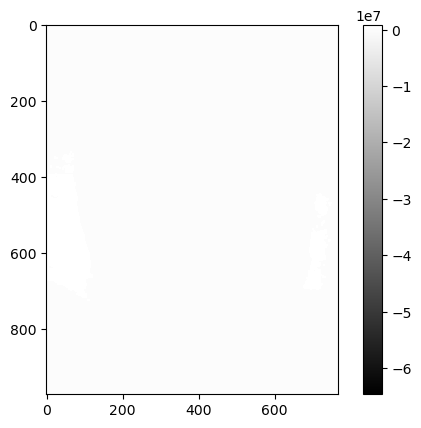

In [214]:
plt.imshow(-np.log(trafo(normal_xr)) / drr_img.view(972,768).cpu().numpy(), cmap="gray")
plt.colorbar()

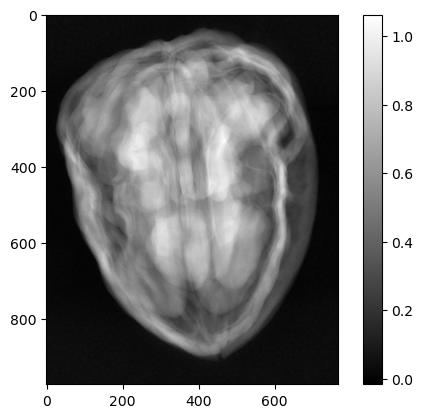

In [187]:
plt.imshow(-np.log(trafo(normal_xr)), cmap="gray")
plt.colorbar()

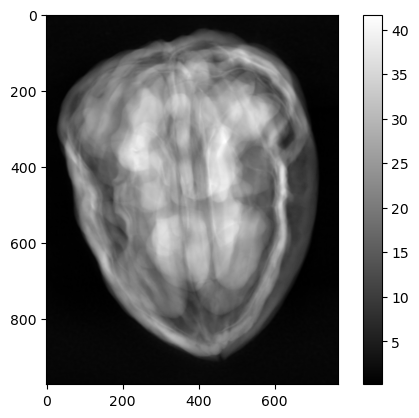

In [179]:
plt.imshow(drr_img.view(972,768).cpu().numpy(), cmap='gray')
plt.colorbar()

In [61]:

drr = DRR(
    subject,
    sdd=199.0,
    height=972,
    width=768,
    delx=0.074800,
    renderer="trilinear",
).cuda()

In [76]:
s.shape

torch.Size([1, 972, 768, 3])

In [169]:
drr_img = drr.renderer(subject.volume.data.squeeze().cuda(), s.cuda(), t.cuda())

In [125]:
drr_img.shape

torch.Size([1, 1, 746496])

In [171]:
xray_p = trafo(xray_0).reshape(972, 768)
drr_p = torch.exp(-drr_img.cpu().double()).view(972,768).numpy()
eps = 1e-6

In [172]:
ratio = xray_p / ( drr_p + eps)

In [173]:
ratio.min(), ratio.max()

(12867.780717189782, 8989543469.291391)

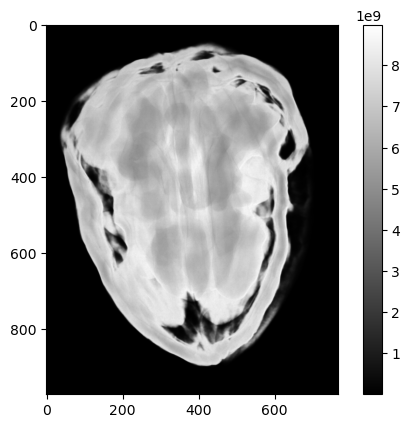

In [174]:
plt.imshow(ratio, cmap='gray')
plt.colorbar()

In [175]:
drr_p.min(), drr_p.max()

(7.840399592972339e-19, 0.8341099033752698)

In [176]:
drr_img.min(), drr_img.max()

(tensor(0.1814, device='cuda:0'), tensor(41.6898, device='cuda:0'))

In [177]:
np.isinf(drr_p).any()

False

In [184]:
just_two = xray_0 - dark
just_two /= flat - dark

UFuncTypeError: Cannot cast ufunc 'divide' output from dtype('float64') to dtype('uint16') with casting rule 'same_kind'

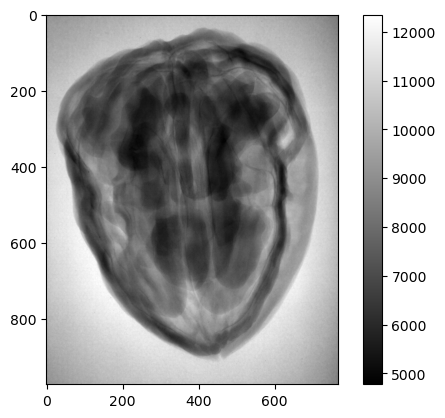

In [183]:
plt.imshow(trafo(xray_0), cmap='gray')
plt.colorbar()

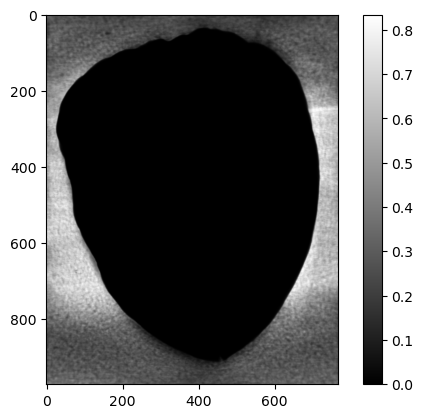

In [178]:
plt.imshow((-drr_img).exp().cpu().view(972, 768), cmap='gray')
plt.colorbar()

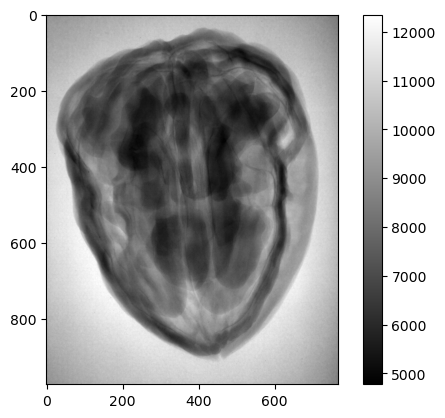

In [143]:
plt.imshow(trafo(xray_0).reshape(972, 768), cmap='gray')
plt.colorbar()

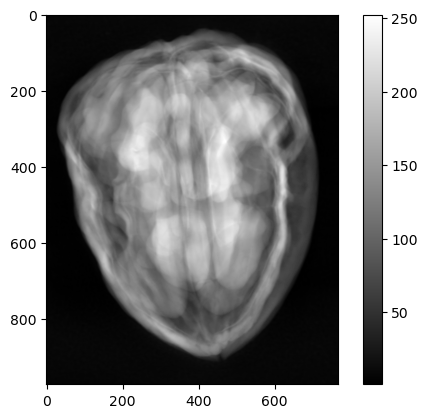

In [140]:
plt.imshow(drr_img.view(972, 768).cpu().numpy(), cmap='gray')
plt.colorbar()

In [62]:
vecs = np.loadtxt(orbit_datapath / f"{geometry_filename}")


In [194]:
orbit_datapath

PosixPath('/data/vision/polina/scratch/walnut/data/Walnut1/Projections/tubeV2')

In [89]:
s, t = get_source_target_vec(vecs[0][None, :])
s = torch.stack(s).cuda()
t = torch.stack(t).cuda()
s = drr.affine_inverse(s.view(1,-1,3))
t = drr.affine_inverse(t.view(1,-1,3))

In [64]:
def get_source_target_vec(vecs):
    projs_rows = 972  # Image height
    projs_cols = 768  # Image width

    sources = []
    targets = []
    for idx in range(len(vecs)):
        src = vecs[idx, :3]  # X-ray source
        det = vecs[idx, 3:6]  # Center of the detector plane
        u = vecs[idx, 6:9]  # Basis vector one of the detector plane
        v = vecs[idx, 9:12]  # Basis vector two of the detector plane

        src = torch.from_numpy(src).to(torch.float32)
        det = torch.from_numpy(det).to(torch.float32)
        u = torch.from_numpy(u).to(torch.float32)
        v = torch.from_numpy(v).to(torch.float32)

        # Create a canonical basis for the detector plane
        rows = torch.arange(-projs_rows // 2, projs_rows // 2) + 0.5 if projs_rows % 2 == 0 else 1.0
        cols = torch.arange(-projs_cols // 2, projs_cols // 2) + 0.5 if projs_cols % 2 == 0 else 1.0

        # Change of basis to u and v from the dataset
        i, j = torch.meshgrid(rows, cols, indexing="ij")
        x = torch.einsum("ij, n -> ijn", j, -u)
        y = torch.einsum("ij, n -> ijn", i, v)

        # Move the center of the detector plane to `det`
        source = src
        target = det + x + y
        source = source.expand(target.shape)
        sources.append(source.flip([1,2]))
        targets.append(target.flip([1,2]))
    return sources, targets

In [283]:
datapath = Path('/data/vision/polina/scratch/walnut/data/Walnut3/')
subject = read(datapath / "gt.nii.gz")

xray_0 = imageio.imread(datapath /'Projections/tubeV2/scan_000000.tif')
dark = imageio.imread(datapath /'Projections/tubeV2/di000000.tif')
flat_0 = imageio.imread(datapath /'Projections/tubeV2/io000000.tif')
flat_1 = imageio.imread(datapath /'Projections/tubeV2/io000001.tif')
flat = (flat_0 + flat_1) / 2
normal_xr = (xray_0 - dark) / (flat - dark)
drr = DRR(
    subject,
    sdd=199.0,
    height=972,
    width=768,
    delx=0.074800,
    renderer="trilinear",
).cuda()


vecs = np.loadtxt(datapath / "Projections/tubeV2/scan_geom_corrected.geom")
s, t = get_source_target_vec(vecs[0][None, :])
s = torch.stack(s).cuda()
t = torch.stack(t).cuda()
s = drr.affine_inverse(s.view(1,-1,3))
t = drr.affine_inverse(t.view(1,-1,3))
drr_img = drr.renderer(subject.volume.data.squeeze().cuda(), s.cuda(), t.cuda())


ratio =((drr_img).view(972,768).cpu().numpy()) / (-np.log(trafo(normal_xr)) +eps)


<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0


In [281]:
ratio.mean(), ratio.std()

(72.05342077099081, 3595.1810710859436)

In [268]:
(-np.log(trafo(normal_xr))).max()

1.0787349794701206

In [245]:
(drr_img+1e-10).view(972,768).cpu().numpy().max()

44.937653

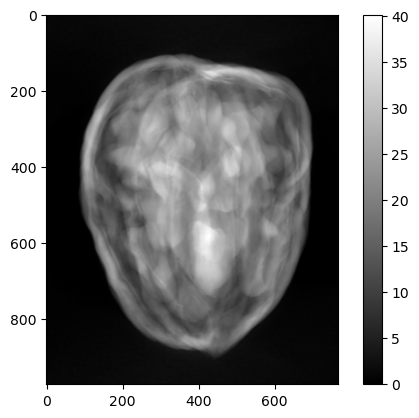

In [284]:
x = -np.log(trafo(normal_xr))
x = drr_img.view(972,768).cpu().numpy()
plt.imshow(x , cmap='gray')
plt.colorbar()

In [250]:
ratio.mean(), ratio.std()

(0.02274946690998082, 0.011636817284798397)